In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.src.layers import Bidirectional, LSTM, InputLayer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping

from utils.dataset_tools import DatasetTools

2025-10-12 19:33:09.117018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760290389.140976   20458 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760290389.150027   20458 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760290389.167206   20458 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760290389.167227   20458 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760290389.167230   20458 computation_placer.cc:177] computation placer alr

In [2]:
import gc
tf.keras.backend.clear_session()
gc.collect()

0

In [3]:
DATASET_PATH = '../dataset/fixed_augmented_dataset.csv'
df = pd.read_csv(DATASET_PATH)
df.head()

,sample_id,frame,label,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,...,landmark_18_z,landmark_19_x,landmark_19_y,landmark_19_z,landmark_20_x,landmark_20_y,landmark_20_z,landmark_21_x,landmark_21_y,landmark_21_z
0,0,0,Y,0.004203,0.000651,0.008161,-0.048246,0.005667,0.004781,-0.071473,...,-0.012839,0.031399,-0.181194,-0.032711,0.023335,-0.226115,-0.038200,0.025997,-0.283913,-0.038001
1,0,1,Y,-0.005988,-0.065978,0.008947,-0.033615,-0.096414,-0.025618,-0.079886,...,0.006703,0.011817,-0.283714,-0.021039,0.014646,-0.290970,-0.008102,-0.000139,-0.334014,-0.005190
2,0,2,Y,-0.000792,-0.093575,0.006636,-0.049848,-0.120680,-0.019714,-0.094480,...,-0.030904,0.011683,-0.311241,-0.034277,0.006597,-0.359876,-0.031719,0.002172,-0.388159,-0.011762
3,0,3,Y,-0.031170,-0.135088,-0.002417,-0.044940,-0.165431,-0.024812,-0.059180,...,0.000000,-0.001518,-0.348757,-0.035873,-0.001939,-0.344533,-0.040972,0.010580,-0.397630,-0.034706
4,0,4,Y,-0.017386,-0.127723,-0.018105,-0.029293,-0.149245,-0.021225,-0.083916,...,-0.017180,-0.006046,-0.302549,-0.033766,0.001081,-0.344521,-0.036471,0.013814,-0.386191,-0.018853


In [4]:
# podział na sekwencje
sequences, labels = DatasetTools.divide_into_sequences(df)

# normalizacja punktów względem nadgarstka
# sequences = np.array([DatasetTools.normalize_wrist(seq) for seq in sequences])

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(labels)  # 'A'...'Z' itd. -> 0...35

# One-hot encoding (36 klas)
y_cat = tf.keras.utils.to_categorical(y, num_classes=len(encoder.classes_))

# Konwersja typów
X = sequences.astype(np.float32)
print(X.shape, y_cat.shape)


(7749, 30, 63) (7749, 36)


In [5]:
# najpierw train+val vs test (np. 70% : 30%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_cat, test_size=0.3, random_state=42, stratify=y
)

# następnie train vs val (np. 80% : 20% z trainval)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=np.argmax(y_trainval, axis=1)
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)


Train: (4339, 30, 63) (4339, 36)
Val: (1085, 30, 63) (1085, 36)
Test: (2325, 30, 63) (2325, 36)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def create_1dcnn_model(input_shape, num_classes):
    model = Sequential([
    InputLayer(shape=input_shape),
    Conv1D(16, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Parametry dla PJM
input_shape = (30, 63)   # 30 klatek, 21 punktów * 3 współrzędne
num_classes = 36         # np. 36 liter alfabetu PJM

model = create_1dcnn_model(input_shape, num_classes)
model.summary()


I0000 00:00:1760290450.865023   20458 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1731 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 16)         │         3,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,300 (75.39 KB)

 Trainable params: 19,300 (75.39 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stopping]
)


Epoch 1/60


I0000 00:00:1760290492.237322   20537 service.cc:152] XLA service 0x7fdffc00b650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760290492.237341   20537 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2025-10-12 19:34:52.269764: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760290492.517460   20537 cuda_dnn.cc:529] Loaded cuDNN version 90300


 54/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0737 - loss: 3.5600

I0000 00:00:1760290495.975480   20537 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.1126 - loss: 3.4179 - val_accuracy: 0.2940 - val_loss: 2.4331
Epoch 2/60
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3485 - loss: 2.1696 - val_accuracy: 0.4802 - val_loss: 1.6862
Epoch 3/60
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5329 - loss: 1.4773 - val_accuracy: 0.6147 - val_loss: 1.2178
Epoch 4/60
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6319 - loss: 1.1141 - val_accuracy: 0.7051 - val_loss: 0.9504
Epoch 5/60
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7297 - loss: 0.8730 - val_accuracy: 0.7438 - val_loss: 0.8024
Epoch 6/60
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7747 - loss: 0.7156 - val_accuracy: 0.7558 - val_loss: 0.7353
Epoch 7/60
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7827 - loss: 0.6685 - val_accuracy: 0.7834 - val_loss: 0.6496
Epoch 8/60
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8227 - loss: 0.5333 - val_accuracy: 0.8304 - va

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 0.3526
Test accuracy: 0.9140


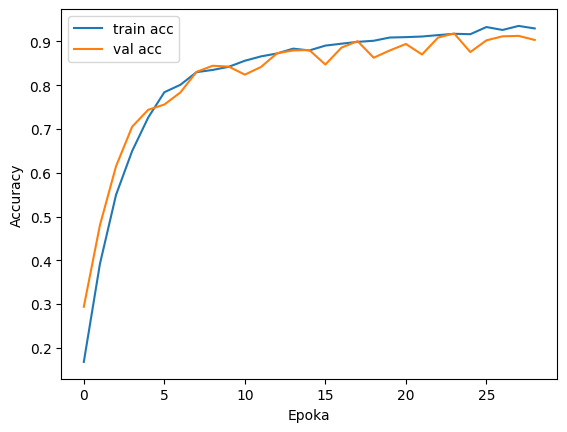

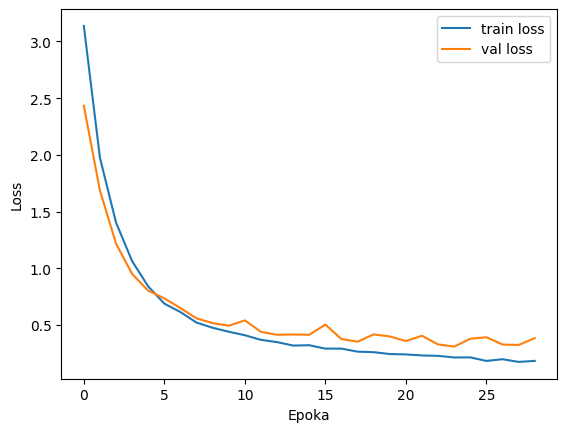

In [9]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
import os
from datetime import datetime

# Ustal dzisiejszą datę
today_str = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

# Ścieżka zapisu modeli
save_dir = f"../model/{today_str}"
os.makedirs(save_dir, exist_ok=True)

# Ścieżki plików
cnn1d_path = os.path.join(save_dir, "cnn1d_model.keras")
labels_path = os.path.join(save_dir, "labels.txt")

# Zapis modelu
model.save(cnn1d_path)

with open(f'../model/{today_str}/labels.txt', 'w+') as f:
    for label in encoder.classes_:
        f.write(label + '\n')

print(f"Modele i etykiety zapisano w folderze: {save_dir}")


Modele i etykiety zapisano w folderze: ../model/2025-10-12-19:35:37


In [11]:
import gc

del model
del X_train, X_val, X_test
del y_train, y_val, y_test
gc.collect()


4302